In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%config IPCompleter.greedy=True 

# Left 20%, Right 80%

suppose the probability distribution of getting reward is constant.

only two choise, left or right.

there would be no states but the learning change would be marked by time

the randomness of exploring instead of always choose the maximum expectation is modelled by sigmoid function, which makes such randomness constantly changing along time

# Updates: Added the using two different learning when Fail vs. Success rat.(FSrat)

In [2]:
# some constants
obs_size = 2 # get 0 or 1 as reward
action_size = 2 #turn left or right
alpha = 0.2 #learning rate
beta = 4 # sharpness of sigmoid; this could be dynamic
gamma = 0
iteration = 80000
every_it_print=1000

# Env Policy
left = 0.2 # probablity of reward in left
right = 1 - left # probability of reward in right

In [3]:
# sigmoid function for nd; return the value of sigmoid with argument beta
# q can be n dimensional, either list or int/float
# beta should be between 0 and 1; determine the sharpness of sigmoid
# we can also try different functions here
def sigmoid(beta,q):
    q=np.array(q)
    val = 1/(1+np.exp(0-beta*q))
    return val
def ratchose(Q): # 0 means left
    if random.uniform(0,1)<sigmoid(beta,Q[0]-Q[1]):
        return np.array([1,0])
    else:
        return np.array([0,1]) 
    
# parameter: action, a list of numpy arrays of action data; reward, a list of np array of reward data
# beta, sharpness of sigmoid; alpha, learning rate
# return the sum of log-likelihood
def neg_log_likelihood(alpha,beta,actions,rewards,Q=[0,0],gamma=0): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = actions[i]
        rew = rewards[i]
        Q = Q + alpha*turn*(rew + gamma*np.max(Q)-Q)
        dQ = Q[0] - Q[1]
        if np.array_equal(turn,np.array([1,0])):
            prob = 1/(np.exp(0-beta*dQ)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*dQ)+1)
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll

# params = [alpha0,beta0]
# args = [actions,rewards]
def helper_func(params,args):
    alpha0 = params[0]
    beta0 = params[1]
    actions = args[0]
    rewards = args[1]
    
    sum_ll = neg_log_likelihood(alpha0,beta0,actions,rewards)
    
    return sum_ll

In [4]:
# Experiment
# reward = (1,0) represent reward is on the left, (0,1) right
# turn = (1,0) represent rat is on the left, (0,1) right

l_rat = 0.5 # evaluation from rat on how likely the reward is on left
r_rat = 0.5 # that for right
reward_rat = 0 # reward got by rat by last action; = reward
exp = 0 # action that maximize reward; 0 for left, 1 for right

count = 0 # count for continuous success of choosing the advantageous action(here, the right)
Q = np.zeros(2)

#logs
rewards=[]
Qlog=[]
temp=[]

for i in range(iteration):
            
    # 0. get choice from rat 
    
    turn = ratchose(Q)

    # 0. set reward 
    reward_site = random.uniform(0,1)
    if reward_site < right and np.array_equal(turn,np.array([0,1])):
    #if the rat goes right and the reward is on the right
        reward = np.array((0,1))
    elif reward_site >= right and np.array_equal(turn,np.array([1,0])):
        reward = np.array((1,0))
    else:
        reward=np.array((0,0))
    rewards.append(reward)
    
    # 2. update rat's information 
    # Q will be between 0 and 5
    Q = Q + alpha*turn*(reward + gamma*np.max(Q)-Q) # I think this is where it went wrong
    Qlog.append(Q)
    # you should only update the action taken

#     l_rat = 1-(sigmoid(beta,Q[0])/(sigmoid(beta,Q[0])+sigmoid(beta,Q[1])))
#     r_rat=1-3
    ratchose(Q)
    
    # I changed this function
    # 3. update count
    if np.array_equal(turn,np.array([1,0])):
        count = 0
    elif np.array_equal(turn,np.array([0,1])):
        count = count + 1
        
        
    # Show ongoing results
    if i%every_it_print==0:
#         print(np.mean(np.array(Qlog)[:,0])) # print the average of left
        temp.append(np.mean(np.array(Qlog)[:,0]))


    # end experiment if rat made more than 10 times right turn, which has prob < 0.00098 by purely random choice
#     if i == 280: #abs(r_rat-right < 0.01) # count > 10
#         print('The rat might has learned somthing. Iteration number:')
#         print(Q)

#         break

# Varience

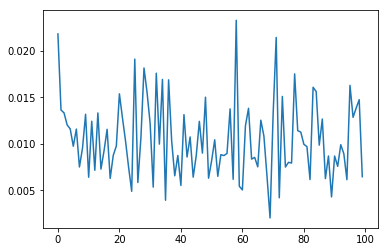

In [5]:
out=[]
chulks=100
for i in range(chulks):
    out.append(np.var(np.array(Qlog)[int(i*len(Qlog)/chulks):int((i+1)*len(Qlog)/chulks),0]))
plt.plot(out)

# Trying a different implementation
## each rat has a log of Q values, actions,likelihood-<rat.Qlog>,<rat.choiceLog>,<rat.lhLog>
## each environment has a log of observations-<env.obslog>
## the lhLog logs the likelihood of going left

In [80]:
class toyQ_2choice:
    '''a unchanging env with probability of giving one
    of two rewards based on params to two different choices'''
    obs_size=1
    action_size=2
    def __init__(self,left=0.2,right=0.8,state=0):
        self.left=left
        self.right=right
        self.obslog=[]
        self.state=state
    def step(self,action,state=0):
        '''takes in the action param as a int of 0 or 1
        where 0 is go left and 1 is to right, and returns
        a return reward where 0 is no reward'''
        reward_site = random.uniform(0,1)
        if reward_site < self.right and np.array_equal(action,np.array([0,1])):
            #if the rat goes right and the reward is on the right
            obs=np.array([0,1])
        elif reward_site >= self.right and np.array_equal(action,np.array([1,0])):
            obs=np.array([1,0])
        else:
            obs=np.array([0,0])
        self.obslog.append(obs)
        return obs
    
class WSLS_rat: # to-do
    pass

class sig_rat:
    def __init__(self,env,alpha=0.2,beta=4,gamma=0):
        # alpha-learning rate, beta-sigmoid slop, gamma-discount factor of future reward
        '''Takes in the beta, gamma ,and the 
        environment of the rat'''
        self.lhLog=[]
        self.choiceLog=[]
        self.beta=beta
        self.gamma=gamma
        self.env=env
        self.alpha=alpha
        self.action_size=env.action_size
        self.obs_size=env.obs_size
        self.Q=np.zeros((self.obs_size,)+(self.action_size,)) # Q-table starts from 0
        self.Qlog=np.zeros((self.obs_size,)+(self.action_size,))
    def get_choice(self): # 0 means left
        lh=sigmoid(self.beta,self.Q[self.env.state][0]-self.Q[self.env.state][1])
        self.lhLog.append(lh)
        if random.uniform(0,1)<lh:
            self.choice=np.array([1,0])
        else:
            self.choice=np.array([0,1])
        self.choiceLog.append(self.choice)
        return self.choice
    def update(self,obs):
        '''Takes obs/reward and update its Q-table'''
        self.Q[self.env.state] = self.Q[self.env.state] + self.alpha*self.choice*\
        (obs + self.gamma*np.max(self.Q[self.env.state])-self.Q[self.env.state])
        self.Qlog=np.vstack((self.Qlog,self.Q))
        return self.Q[self.env.state]
    
class FSrat:
    def __init__(self,env,alphaF=0.2,alphaS=0.1,beta=4,gamma=0): # fail and success
        # alpha-learning rate, beta-sigmoid slop, gamma-discount factor of future reward
        '''Takes in the beta, gamma ,and the 
        environment of the rat'''
        self.lhLog=[]
        self.choiceLog=[]
        self.beta=beta
        self.env=env
        self.alphaF=alphaF
        self.gamma=gamma
        self.alphaS=alphaS
        self.action_size=env.action_size
        self.obs_size=env.obs_size
        self.Q=np.zeros((self.obs_size,)+(self.action_size,)) # Q-table starts from 0
        self.Qlog=np.zeros((self.obs_size,)+(self.action_size,))
    def get_choice(self): #[1,0] means left
        lh=sigmoid(self.beta,self.Q[self.env.state][0]-self.Q[self.env.state][1])
        self.lhLog.append(lh)
        if random.uniform(0,1)<lh:
            self.choice=np.array([1,0])
        else:
            self.choice=np.array([0,1])
        self.choiceLog.append(self.choice)
        return self.choice
    def update(self,obs):
        '''Takes obs/reward and update its Q-table'''
        used_alpha=[self.alphaF,self.alphaS][max(obs)]
        self.Q[self.env.state] = self.Q[self.env.state] + used_alpha*self.choice*\
        (obs + self.gamma*np.max(self.Q[self.env.state])-self.Q[self.env.state])
        self.Qlog=np.vstack((self.Qlog,self.Q))
        return self.Q[self.env.state]
    
    pass

class SQFSrat: # Single Q Failure-Success rat
    def __init__(self,env,alphaF=0.2,alphaS=0.1,beta=4,gamma=0):
        # alpha-learning rate, beta-sigmoid slop, gamma-discount factor of future reward
        '''Takes in the beta, gamma ,and the 
        environment of the rat'''
        self.lhLog=[]
        self.choiceLog=[]
        self.beta=beta
        self.gamma=gamma
        self.env=env
        self.alpha=alpha
        self.action_size=env.action_size
        self.obs_size=env.obs_size
        self.Q=0 # Q starts from 0
        self.Qlog=[0]
    def get_choice(self): # 0 means left
        lh=sigmoid(self.beta,self.Q)
        self.lhLog.append(lh)
        if random.uniform(0,1)<lh:
            self.choice=np.array([1,0])
        else:
            self.choice=np.array([0,1])
        self.choiceLog.append(self.choice)
        return self.choice
    def update(self,obs):
        '''Assumes that going going left and get no reward is the
        same as going right and get an reward, and going right and
        not getting a reward is the same as going left and not getting'''
        if (obs==np.array([1,0])).all() and (self.choice==np.array([1,0])).all() or\
        (obs==np.array([0,0])).all() and (self.choice==np.array([0,1])).all():
            self.Q=(1-self.alpha)*self.Q+self.alpha*1 # going left and getting an reward of one
            self.Q=(1-self.alpha)*self.Q+self.alpha*1
        elif ((obs==np.array([0,0])).all() and (self.choice==np.array([1,0]))).all() or\
        (obs==np.array([0,1])).all() and (self.choice==np.array([0,1])).all():
            self.Q=(1-self.alpha)*self.Q # going left and not getting an reward
            self.Qlog.append(self.Q)
        return self.Q    
    
    
def train_rat(env,rat,it_num,every=500):
    for i in range(it_num):
        action=rat.get_choice()
        obs=env.step(action)
        rat.update(obs)
        if i%every==-1:
            print(np.mean(rat.Qlog,axis=0))
    return env,rat


# Testing(SQFSrat)

In [132]:
env=toyQ_2choice()
rat=SQFSrat(env,alphaF=0.025,alphaS=0.1)
env,rat=train_rat(env,rat,300)
np.mean(rat.Qlog)

0.23381658902447905

# Testing(FSRat)

In [21]:
env=toyQ_2choice()
rat=FSrat(env,alphaF=0.025,alphaS=0.1)
env,rat=train_rat(env,rat,300)
obslog=np.array(env.obslog)
choicelog=np.array(rat.choiceLog) 
print('reward_log:',np.sum(obslog,axis=0))
print('choice_log:',np.sum(choicelog,axis=0))
rat.Q

reward_log: [  8 217]
choice_log: [ 30 270]


array([[0.46259591, 0.95339882]])

# Testing(SigRat)

In [62]:
env=toyQ_2choice()
rat=sig_rat(env,alpha=0.05,beta=2)
env,rat=train_rat(env,rat,300)
obslog=np.array(env.obslog)
choicelog=np.array(rat.choiceLog) 
print('reward_log:',np.sum(obslog,axis=0))
print('choice_log:',np.sum(choicelog,axis=0))
rat.Q

reward_log: [ 22 160]
choice_log: [ 88 212]


array([[0.238558  , 0.73693724]])

# Likelihood Log

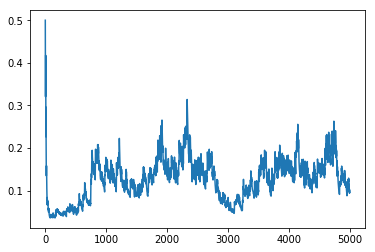

In [8]:
plt.plot(rat.lhLog) # the model prediction of going left

# Viusalization

(array([ 642.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4358.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

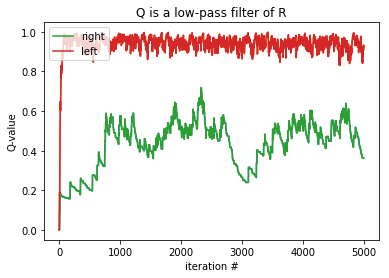

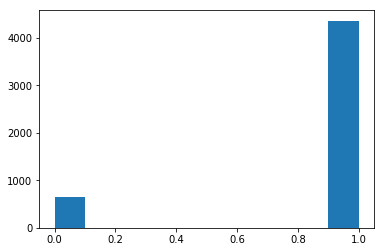

In [9]:
qlog=np.array(rat.Qlog)[:] # first 1000 times
plt.figure(1)
plt.plot(qlog[:,0])
plt.plot(qlog[:,1])
line0, = plt.plot(qlog[:,0], label='right')
line1, = plt.plot(qlog[:,1], label='left')
plt.legend(loc='upper left')
plt.title('Q is a low-pass filter of R')
plt.xlabel('iteration #')
plt.ylabel('Q-value')
plt.figure(2)
alog=np.array(rat.choiceLog)
plt.hist(alog[:,1])

# MLE

In [63]:
actions = rat.choiceLog
rewards = env.obslog

In [10]:
bvals = np.linspace(0,10,50)
avals = np.linspace(0,1,200)
# ll = [neg_log_likelihood(0.2,b,actions,rewards) for b in bvals]
ll = [neg_log_likelihood(a,2,actions,rewards) for a in avals]
llb = [neg_log_likelihood(0.05,b,actions,rewards) for b in bvals]
plt.figure(1)
plt.plot(avals, ll)
plt.title('Alpha')
plt.figure(2)
plt.plot(bvals, llb)
plt.title("Beta")
plt.show()

NameError: name 'actions' is not defined

In [65]:
# function that estimates the maximum-likelihood beta_hat numerically
# parameters: actions, a numpy array recording action of agent in each turn; beta is the parameter in density func
# return minimization summary and print beta_hat
def MLE_grid(actions,rewards,alpha0,beta0):
    initial_guess = [alpha0,beta0]
    args = [actions,rewards]
    result = minimize(helper_func,initial_guess,args=args)
    if(result.success):
        #print(result.message)
        #print('The MLE for beta is', result.x)
        #print('Iteration =', result.nit)
        a=0
    else:
        print('The optimization did not converge, beta0 equals', beta0,', and alpha0 equals',alpha0)
    return result
    
# return mse between simulated Q and Q_hat calculated with optimal beta from MLE
def Q_distance(iteration,alpha0,beta0):
    env = toyQ_2choice()
    rat = sig_rat(env, alpha=alpha0, beta=beta0)
    env,rat = train_rat(env,rat,iteration)
    Q = np.array(rat.Qlog)
    actions = rat.choiceLog
    rewards = env.obslog
    
    result = MLE_grid(actions,rewards,alpha0,beta0)
    alpha_hat = result.x[0]
    beta_hat = result.x[1]
    
    rat_hat = sig_rat(env, alpha=alpha_hat, beta=beta_hat)
    env,rat_hat = train_rat(env,rat_hat,iteration)
    Q_hat = np.array(rat_hat.Qlog)
    d
    #Q[0]=[0,0] does not matter
    mse = np.linalg.norm(Q-Q_hat)**2/iteration 
    #axis=None perform mean elementwise   (np.square(Q-Q_hat)).mean(axis=None)*2
    
    return mse
    
    